# Mountain cart

This is the notebook for the implement the mountain cart problem. 
It is divided into:
1. Random Agent
2. DQN approach
3. Dyna approach

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

# **1.** Random Agent

In [9]:
from RandomAgent import RandomAgent

env = gym.make('MountainCar-v0') #, render_mode = "human"
agent = RandomAgent(env)
num_episodes = 100

rewards = []
for episode in tqdm(range(num_episodes)):
    seed = np.random.randint(0, 100000)
    state = env.reset(seed=seed)
    done = False
    total_reward = 0

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, truncated, _ = env.step(action)
        agent.observe(state, action, next_state, reward)
        agent.update()
        total_reward += reward
        state = next_state

    rewards.append(total_reward)

100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


Text(0.5, 0, 'Episode number')

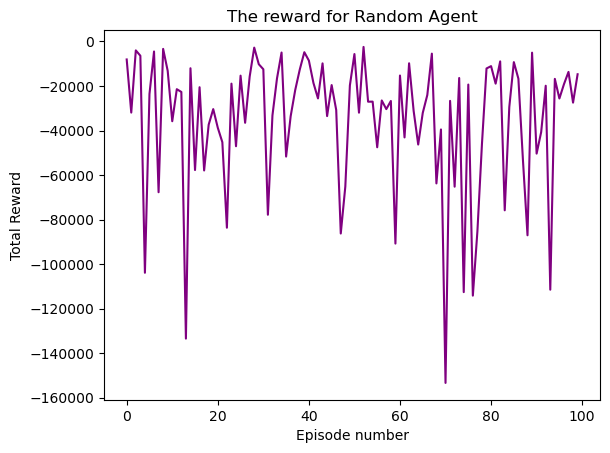

In [10]:
fig, ax = plt.subplots()
ax.plot(rewards, color = "purple")
ax.set_title("The reward for Random Agent")
ax.set_ylabel("Total Reward")
ax.set_xlabel("Episode number")

In [11]:
n_episodes=100
durations=[]
for i in tqdm(range(n_episodes)):
    t0 = time()
    done = False
    seed = np.random.randint(0, 100000)
    state, info = env.reset(seed=seed), None
    episode_reward = 0
    while not done:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, info = env.step(action)

        episode_reward += reward

        state = next_state
        done = terminated or truncated
    t1=time()
    durations.append(t1-t0)

100%|██████████| 100/100 [00:00<00:00, 445.19it/s]


Text(0.5, 1.0, 'Duration of episodes')

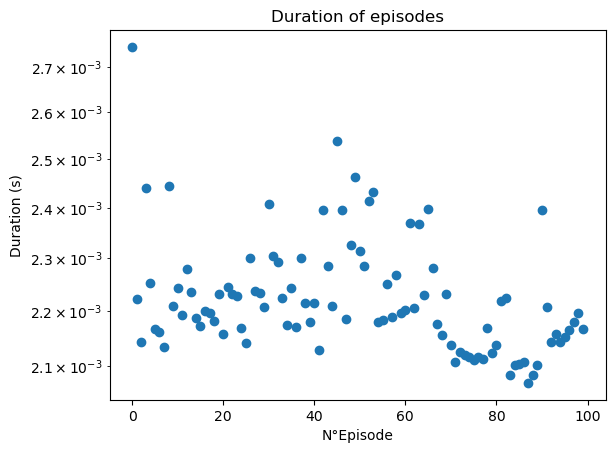

In [12]:
plt.scatter(range(n_episodes),durations)
plt.yscale('log')
plt.xlabel('N°Episode')
plt.ylabel('Duration (s)')
plt.title('Duration of episodes')

# **2.** DQN Agent

In [27]:
from DQN import DQNAgent, DQNnetwork


In [38]:
from DQN import DQNAgent, DQNnetwork

num_episodes = 1000
env = gym.make('MountainCar-v0') #, render_mode = "human"
state_size, action_size = env.observation_space.shape[0], env.action_space.n
agent = DQNAgent(env, state_size, action_size)
rewards, durations = agent.train(env, agent, num_episodes)
agent.save_agent(f"DQN_{num_episodes}_episodes")

100%|██████████| 1000/1000 [24:04<00:00,  1.44s/it] 

Directory created:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_1000_episodes/
Agent saved on path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_1000_episodes/


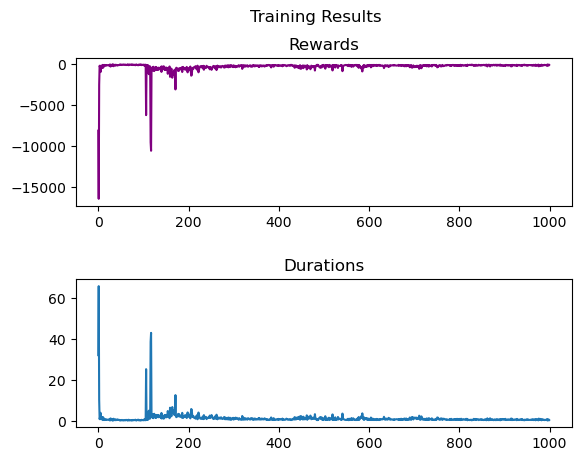

In [39]:
agent.plots()